In [17]:
from pathlib import Path
import sys, os

# 1. cwd is project-root/examples
cwd = Path().resolve()
# 2. project-root is its parent
project_root = cwd.parent

# 3. add project_root to sys.path
sys.path.insert(0, str(project_root))

# debug: make sure 'examples' shows up
# print("PYTHONPATH entries:")
# for p in sys.path[:3]:
#     print(" ", p)
# print("project_root contents:", os.listdir(project_root))

import fire
import numpy as np
import torch
import torchvision
import torchvision.transforms.v2 as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torchmetrics.classification import MulticlassCalibrationError


from pytagi import HRCSoftmaxMetric, Utils, exponential_scheduler
from examples.tagi_resnet_model import resnet18_cifar10
from examples.torch_resnet_model import ResNet18


In [18]:
torch.manual_seed(17)

# Constants for dataset normalization
NORMALIZATION_MEAN = [0.4914, 0.4822, 0.4465]
NORMALIZATION_STD = [0.2470, 0.2435, 0.2616]

def custom_collate_fn(batch):
    # batch is a list of tuples (image, label)
    batch_images, batch_labels = zip(*batch)

    # Convert to a single tensor
    batch_images = torch.stack(batch_images)
    batch_labels = torch.tensor(batch_labels)

    # Flatten images to shape (B*C*H*W,)
    batch_images = batch_images.reshape(-1)

    # Convert to numpy arrays
    batch_images = batch_images.numpy()
    batch_labels = batch_labels.numpy()

    return batch_images, batch_labels


def load_datasets(batch_size: int, framework: str = "tagi"):
    """Load and transform CIFAR10 training and test datasets."""
    transform_train = transforms.Compose(
        [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToImage(),
            transforms.ConvertImageDtype(torch.float32),
            transforms.Normalize(mean=NORMALIZATION_MEAN, std=NORMALIZATION_STD),
        ]
    )

    transform_test = transforms.Compose(
        [
            transforms.ToImage(),
            transforms.ConvertImageDtype(torch.float32),
            transforms.Normalize(mean=NORMALIZATION_MEAN, std=NORMALIZATION_STD),
        ]
    )

    train_set = torchvision.datasets.CIFAR10(
        root="../data/cifar", train=True, download=True, transform=transform_train
    )
    test_set = torchvision.datasets.CIFAR10(
        root="../data/cifar", train=False, download=True, transform=transform_test
    )


    train_loader = DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,
        num_workers=1,
        # collate_fn=custom_collate_fn,
    )
    test_loader = DataLoader(
        test_set,
        batch_size=batch_size,
        shuffle=False,
        num_workers=1,
        # collate_fn=custom_collate_fn,
    )

    return train_loader, test_loader


In [19]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_multiclass_calibration(probs, labels, num_bins=15):
    """
    Plots a multiclass reliability diagram using all class probabilities.

    Parameters:
    - probs: torch.Tensor or np.array, predicted probabilities (N samples, C classes)
    - labels: torch.Tensor or np.array, true labels (N samples)
    - num_bins: int, number of bins for calibration diagram
    """
    # Convert to numpy if they're torch tensors
    if isinstance(probs, torch.Tensor):
        probs = probs.cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.cpu().numpy()

    bin_edges = np.linspace(0.0, 1.0, num_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Dictionary to store (confidence, correctness) pairs per bin
    bin_data = {b: [] for b in range(num_bins)}

    # Process each sample
    for i in range(len(probs)):
        sample_probs = probs[i]
        true_label = labels[i]

        # Process each class probability
        for class_idx, class_prob in enumerate(sample_probs):
            confidence = class_prob
            correctness = 1.0 if class_idx == true_label else 0.0

            # Find the appropriate bin
            for bin_idx in range(num_bins):
                if bin_edges[bin_idx] <= confidence < bin_edges[bin_idx + 1]:
                    bin_data[bin_idx].append((confidence, correctness))
                    break
            else:  # Handle edge case for confidence = 1.0
                if confidence == 1.0 and bin_idx == num_bins - 1:
                    bin_data[num_bins - 1].append((confidence, correctness))

    # Calculate metrics per bin
    accuracies = np.zeros(num_bins)
    avg_confs = np.zeros(num_bins)
    counts = np.zeros(num_bins)

    for bin_idx in range(num_bins):
        if bin_data[bin_idx]:
            confs, corrects = zip(*bin_data[bin_idx])
            accuracies[bin_idx] = np.mean(corrects)
            avg_confs[bin_idx] = np.mean(confs)
            counts[bin_idx] = len(confs)

    # Compute ECE (Expected Calibration Error)
    ece = np.sum(np.abs(accuracies - avg_confs) * counts) / counts.sum()

    # Create plot
    plt.figure(figsize=(10, 8))
    plt.axline((0, 0), (1, 1), linestyle='--', color='gray', alpha=0.7,
               label='Perfect Calibration')

    # Plot bars with different colors based on calibration
    for bin_idx in range(num_bins):
        color = 'dodgerblue' if accuracies[bin_idx] >= avg_confs[bin_idx] else 'salmon'
        plt.bar(
            bin_centers[bin_idx],
            accuracies[bin_idx],
            width=0.8/num_bins,
            color=color,
            edgecolor='black',
            alpha=0.8
        )

    # Plot confidence line
    plt.plot(bin_centers, avg_confs, 's-', color='red', linewidth=2, markersize=8,
             label='Avg Confidence')

    # Add count labels
    for bin_idx in range(num_bins):
        if counts[bin_idx] > 0:
            plt.text(
                bin_centers[bin_idx],
                min(accuracies[bin_idx], avg_confs[bin_idx]) - 0.05,
                f"{int(counts[bin_idx])}",
                ha='center',
                fontsize=9,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2')
            )

    plt.xlabel("Confidence", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.title(f"Multiclass Reliability Diagram (ECE: {ece:.4f})", fontsize=14)
    plt.legend(loc='upper left', fontsize=10)
    plt.grid(alpha=0.3)
    plt.xlim(0, 1)
    plt.ylim(0, 1.05)

    # Add gap histogram
    plt.figure(figsize=(10, 3))
    plt.bar(bin_centers, counts, width=0.8/num_bins, color='mediumseagreen', edgecolor='black')
    plt.xlabel("Confidence", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.title("Sample Distribution Across Bins", fontsize=14)
    plt.grid(alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    return ece

Files already downloaded and verified
Files already downloaded and verified

Test Loss: 0.3491
Test Accuracy: 91.02%

Test Loss: 0.3491
Test Accuracy: 91.02%
Expected Calibration Error (ECE): 0.0479


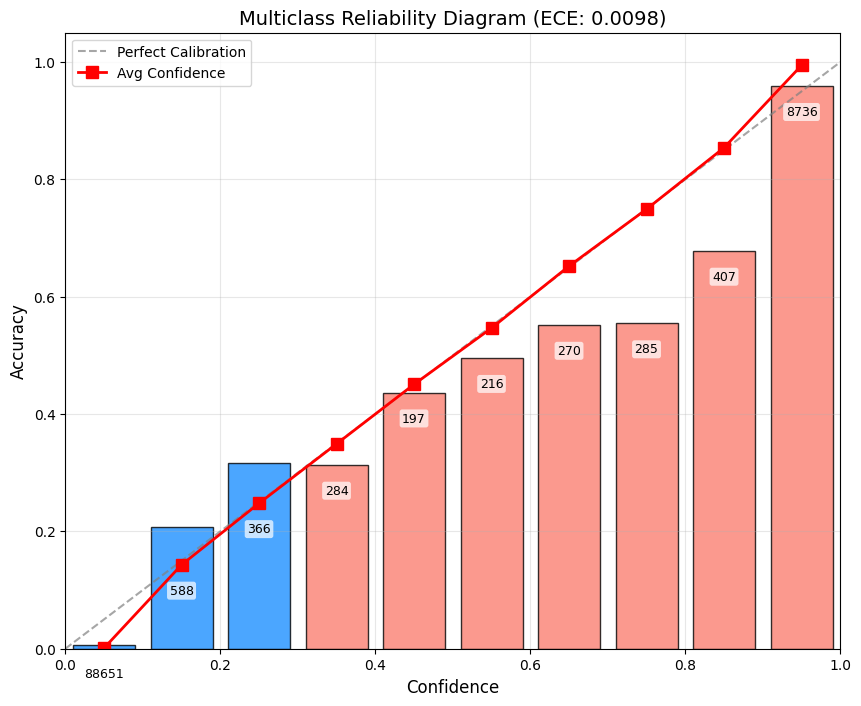

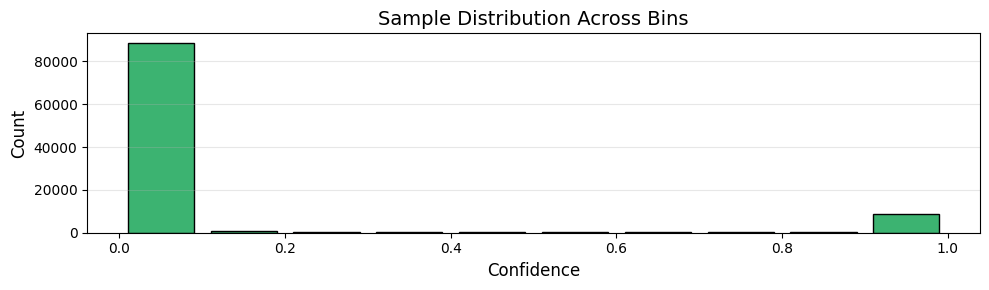

Multiclass Reliability ECE: 0.0098


In [20]:
def evaluate_and_calibrate(model_path: str, batch_size: int = 128, device: str = "cuda"):
    torch_device = torch.device(device)
    if "cuda" in device and not torch.cuda.is_available():
        raise RuntimeError("CUDA is not available. Please check your installation.")

    # Load test data
    train_loader, test_loader = load_datasets(batch_size, "torch")

    # Load the model
    model = ResNet18()
    model.load_state_dict(torch.load(model_path, map_location=torch_device, weights_only=True))
    model.to(torch_device)
    model.eval()

    criterion = nn.CrossEntropyLoss()
    total_loss = 0.0
    correct = 0
    total_samples = 0

    all_probs = []
    all_labels = []

    with torch.no_grad():
        for data, target in test_loader:
            # Convert to tensors if needed
            if not isinstance(data, torch.Tensor):
                data = torch.tensor(data, dtype=torch.float32)
            if not isinstance(target, torch.Tensor):
                target = torch.tensor(target, dtype=torch.long)

            # Reshape flattened data to image format (CIFAR-10: 32x32 pixels, 3 channels)
            if data.dim() == 1:  # Handle flattened input
                # Calculate batch size from target
                current_batch_size = target.shape[0]
                data = data.reshape(current_batch_size, 32, 32, 3)

            # Convert HWC to CHW format if needed
            if data.dim() == 4 and data.shape[-1] == 3:
                data = data.permute(0, 3, 1, 2)

            data = data.to(torch_device)
            target = target.to(torch_device)

            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()

            probs = torch.softmax(output, dim=1)
            preds = probs.argmax(dim=1)
            correct += preds.eq(target).sum().item()
            total_samples += target.size(0)

            all_probs.append(probs)
            all_labels.append(target)

    avg_loss = total_loss / len(test_loader)
    accuracy = correct / total_samples * 100

    print(f"\nTest Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.2f}%")

    # Flatten outputs and compute calibration
    probs_tensor = torch.cat(all_probs, dim=0).cpu()
    labels_tensor = torch.cat(all_labels, dim=0).cpu()

    # Calculate ECE with standard method
    ece_metric = MulticlassCalibrationError(num_classes=probs_tensor.size(1), n_bins=10, norm='l1')
    ece = ece_metric(probs_tensor, labels_tensor)

    print(f"\nTest Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Expected Calibration Error (ECE): {ece:.4f}")

    # Plot multiclass reliability diagram
    multiclass_ece = plot_multiclass_calibration(probs_tensor, labels_tensor, num_bins=10)
    print(f"Multiclass Reliability ECE: {multiclass_ece:.4f}")

# Example usage
evaluate_and_calibrate("../models_bin/cifar_torch_resnet18.bin", batch_size=128, device="cuda")